# Supervised Learning (3) - Neural Networks, Deep Learning
## Machine Learning Lectures by the ESA Data Analytics Team for Operations (DATO)
### [José Martínez Heras](https://www.linkedin.com/in/josemartinezheras/)

## Resouces
This notebook is best followed when watched along to its corresponding [deep learning using convolutional neural networks for hand written recognition **video**](https://dlmultimedia.esa.int/download/public/videos/2048/03/003/4803_003_AR_EN.mp4)

The tutorial about convolutional neural networks can be found in the [2018-MachineLearning-Lectures-ESA **GitHub**](https://github.com/jmartinezheras/2018-MachineLearning-Lectures-ESA)

## Goal of today's project
Classify hand written numbers. The goal is to help post offices to automatically route the mail by reading the hand written zip code. 

### Inspired by
* https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
* https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

## Import libraries

In [1]:
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC

C:\Users\jamheras\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. 

Wikipedia contributors, "MNIST database," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=MNIST_database&oldid=829836442 (accessed March 22, 2018).

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

11493376/11490434 [==============================] - 7s 1us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


### Exploratory Data Analysis (EDA)

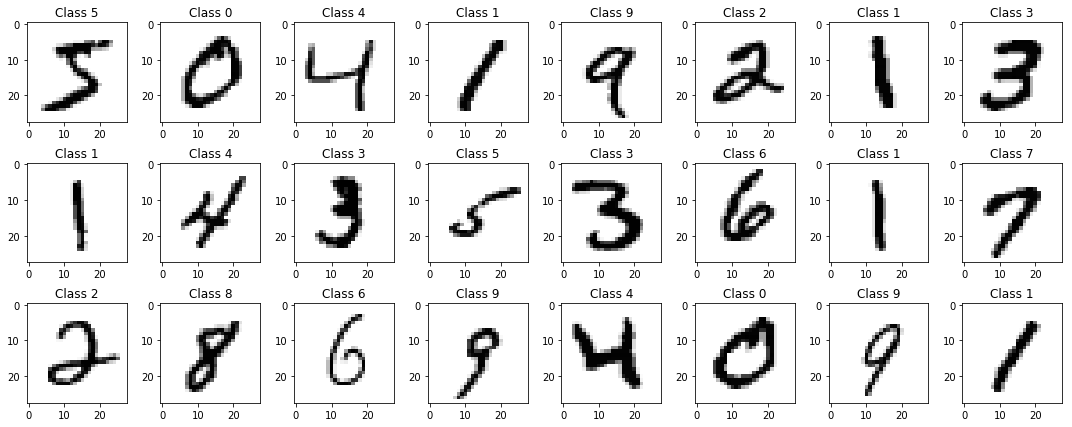

In [3]:
plt.figure(figsize=(15,6))
for i in range(24):
    plt.subplot(3,8,i+1)
    plt.imshow(255-X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
plt.tight_layout()

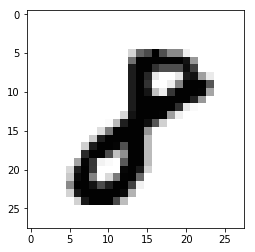

In [4]:
 plt.imshow(255-X_train[31], cmap='gray', interpolation='none')

In [5]:
for x in X_train[31]:
    for i in x:
        print(str(i).rjust(4), end='')
    print()

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  42 154 180 255 176 118 118  16   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 142 253 253 253 253 253 253 236 103   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 227 253 253 204 177 177 177 243 191   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 227 253 216  22   0   0  23 227 238  96  21

### Let's see the distribution of the digits

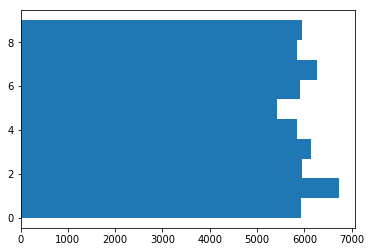

In [6]:
plt.hist(y_train, bins=10, orientation='horizontal');

## Data Preparation
### Scale data to [0,1] instead of [0, 255]

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28)
Testing matrix shape (10000, 28, 28)


### one-hot encode the class output

In [8]:
y_train[:3]

array([5, 0, 4], dtype=uint8)

In [9]:
n_classes = len(np.unique(y_train))
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [10]:
Y_train[:3]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

### prepare 2 sets of data
#### The flat version for considering each pixel as an input
Since the images are 28x28 pixels, there are 784 pixels

In [11]:
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)
print("Training X_train_flat shape", X_train_flat.shape)
print("Testing X_test_flat shape", X_test_flat.shape)

Training X_train_flat shape (60000, 784)
Testing X_test_flat shape (10000, 784)


#### In the case we want to process them as images, we need to take into account the channels
In this example is not particularly relevant, but it is generally needed as images normally have 3 channels (e.g. RGB: Red, Green, Blue). Other examples could be channels of different bands (e.g. infrared, ultra-violet, etc.)

In [12]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)
print("Input shape", input_shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)
Input shape (28, 28, 1)


## Feature Engineering
We are not doing any feature engineering today. We will work with the images as they are

## Machine Learning
### Neural network using each pixel as an input

In [13]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
        
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train_flat, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_flat, Y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.5052 - acc: 0.8518 - val_loss: 0.2203 - val_acc: 0.9348
Epoch 2/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.2652 - acc: 0.9217 - val_loss: 0.1584 - val_acc: 0.9532
Epoch 3/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.2157 - acc: 0.9377 - val_loss: 0.1358 - val_acc: 0.9603
Epoch 4/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.1874 - acc: 0.9449 - val_loss: 0.1137 - val_acc: 0.9663
Epoch 5/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.1678 - acc: 0.9500 - val_loss: 0.1051 - val_acc: 0.9682
Epoch 6/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.1566 - acc: 0.9531 - val_loss: 0.0946 - val_acc: 0.9722
Epoch 7/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.1438 - acc: 0.9569 - val_loss: 0.0970 - val_acc

### Quite good results! Let's try with a deeper network

In [15]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train_flat, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_flat, Y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.6482 - acc: 0.7980 - val_loss: 0.2146 - val_acc: 0.9354
Epoch 2/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.3172 - acc: 0.9080 - val_loss: 0.1640 - val_acc: 0.9501
Epoch 3/10
60000/60000 [==============================] - 3s 45us/step - loss: 0.2581 - acc: 0.9255 - val_loss: 0.1366 - val_acc: 0.9589
Epoch 4/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.2259 - acc: 0.9342 - val_loss: 0.1268 - val_acc: 0.9627
Epoch 5/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.2029 - acc: 0.9410 - val_loss: 0.1160 - val_acc: 0.9649
Epoch 6/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.1882 - acc: 0.9449 - val_loss: 0.1058 - val_acc: 0.9678
Epoch 7/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.1772 - acc: 0.9482 - val_loss: 0.0926 - val_acc

### Let's use now a convolutional network

In [17]:
cnn = Sequential()
cnn.add(Convolution2D(8, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Convolution2D(16, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.5))
 
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                25664     
__________

In [18]:
cnn.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, Y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.7768 - acc: 0.7489 - val_loss: 0.1571 - val_acc: 0.9555
Epoch 2/10
60000/60000 [==============================] - 18s 303us/step - loss: 0.3427 - acc: 0.8961 - val_loss: 0.1069 - val_acc: 0.9680
Epoch 3/10
60000/60000 [==============================] - 19s 309us/step - loss: 0.2757 - acc: 0.9174 - val_loss: 0.0855 - val_acc: 0.9735
Epoch 4/10
60000/60000 [==============================] - 18s 303us/step - loss: 0.2369 - acc: 0.9288 - val_loss: 0.0772 - val_acc: 0.9756
Epoch 5/10
60000/60000 [==============================] - 19s 323us/step - loss: 0.2163 - acc: 0.9355 - val_loss: 0.0651 - val_acc: 0.9790
Epoch 6/10
60000/60000 [==============================] - 19s 316us/step - loss: 0.2022 - acc: 0.9397 - val_loss: 0.0619 - val_acc: 0.9800
Epoch 7/10
60000/60000 [==============================] - 24s 392us/step - loss: 0.1912 - acc: 0.9436 - val_loss: 0.

The Convolutional Neural Network performs better with fewer parameters

## So far so good, but what about if we would have a *more difficult* problem?
**56x56** instead of 28x28 with the number in a random location
### Prepare data

In [19]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
X_extendend_train = np.zeros((60000, 56, 56))
X_extendend_test = np.zeros((10000, 56, 56))

In [20]:
for i in range(60000):
    posx = np.random.randint(0, 28)
    posy = np.random.randint(0, 28)
    X_extendend_train[i,posx:posx+28, posy:posy+28] = X_train[i]
for i in range(10000):
    posx = np.random.randint(0, 28)
    posy = np.random.randint(0, 28)
    X_extendend_test[i,posx:posx+28, posy:posy+28] = X_test[i]

In [21]:
X_train_flat_extended = X_extendend_train.reshape(-1, 56*56)
X_test_flat_extended = X_extendend_test.reshape(-1, 56*56)
print("Training X_train_flat shape", X_train_flat_extended.shape)
print("Testing X_test_flat shape", X_test_flat_extended.shape)

Training X_train_flat shape (60000, 3136)
Testing X_test_flat shape (10000, 3136)


In [22]:
# input image dimensions
img_rows_extended, img_cols_extended = 56, 56

if K.image_data_format() == 'channels_first':
    X_train_extended = X_extendend_train.reshape(X_extendend_train.shape[0], 1, img_rows_extended, img_cols_extended)
    X_test_extended = X_extendend_test.reshape(X_extendend_test.shape[0], 1, img_rows_extended, img_cols_extended)
    input_shape_extended = (1, img_rows_extended, img_cols_extended)
else:
    X_train_extended = X_extendend_train.reshape(X_extendend_train.shape[0], img_rows_extended, img_cols_extended, 1)
    X_test_extended = X_extendend_test.reshape(X_extendend_test.shape[0], img_rows_extended, img_cols_extended, 1)
    input_shape_extended = (img_rows_extended, img_cols_extended, 1)

print("Training matrix shape", X_train_extended.shape)
print("Testing matrix shape", X_test_extended.shape)
print("Input shape", input_shape_extended)

Training matrix shape (60000, 56, 56, 1)
Testing matrix shape (10000, 56, 56, 1)
Input shape (56, 56, 1)


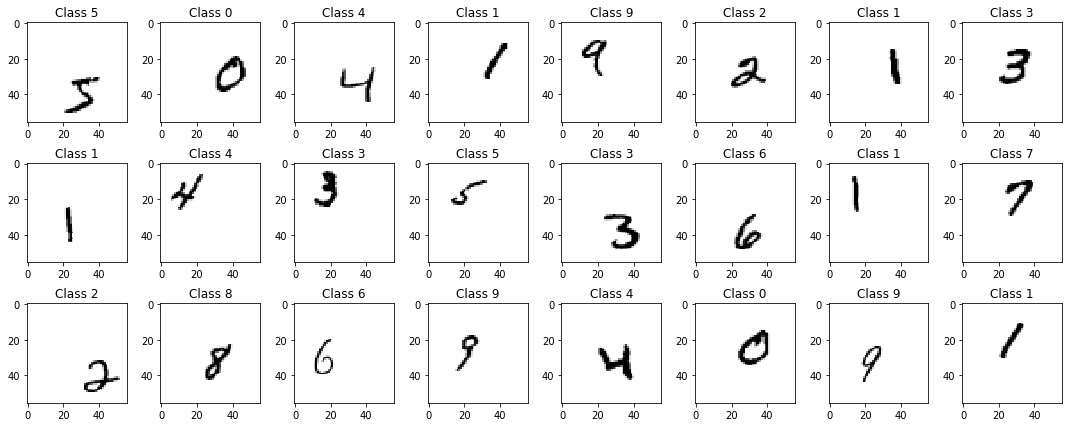

In [23]:
plt.figure(figsize=(15,6))
for i in range(24):
    plt.subplot(3,8,i+1)
    plt.imshow(255-X_extendend_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
plt.tight_layout()

### Simple Network

In [24]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(3136,)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
        
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 402,826
Trainable params: 402,826
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train_flat_extended, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_flat_extended, Y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 177us/step - loss: 14.2283 - acc: 0.1141 - val_loss: 14.2498 - val_acc: 0.1146
Epoch 2/10
60000/60000 [==============================] - 9s 147us/step - loss: 14.0690 - acc: 0.1248 - val_loss: 13.8900 - val_acc: 0.1363
Epoch 3/10
60000/60000 [==============================] - 9s 149us/step - loss: 14.0078 - acc: 0.1292 - val_loss: 14.1713 - val_acc: 0.1200
Epoch 4/10
60000/60000 [==============================] - 9s 151us/step - loss: 13.9243 - acc: 0.1349 - val_loss: 13.8727 - val_acc: 0.1382
Epoch 5/10
60000/60000 [==============================] - 9s 152us/step - loss: 13.8569 - acc: 0.1393 - val_loss: 13.7519 - val_acc: 0.1463
Epoch 6/10
60000/60000 [==============================] - 9s 154us/step - loss: 13.7816 - acc: 0.1442 - val_loss: 13.7431 - val_acc: 0.1468
Epoch 7/10
60000/60000 [==============================] - 9s 156us/step - loss: 13.8239 - acc: 0.1418 - val_l

### Deeper Network

In [26]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(3136,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               401536    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 410,442
Trainable params: 410,442
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train_flat_extended, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_flat_extended, Y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 166us/step - loss: 14.2801 - acc: 0.1077 - val_loss: 14.2516 - val_acc: 0.1149
Epoch 2/10
60000/60000 [==============================] - 10s 159us/step - loss: 14.2509 - acc: 0.1141 - val_loss: 14.2152 - val_acc: 0.1177
Epoch 3/10
60000/60000 [==============================] - 10s 161us/step - loss: 14.2098 - acc: 0.1173 - val_loss: 14.2622 - val_acc: 0.1150
Epoch 4/10
60000/60000 [==============================] - 10s 166us/step - loss: 14.1982 - acc: 0.1182 - val_loss: 14.0263 - val_acc: 0.1290
Epoch 5/10
60000/60000 [==============================] - 10s 165us/step - loss: 14.1795 - acc: 0.1188 - val_loss: 14.1258 - val_acc: 0.1224
Epoch 6/10
60000/60000 [==============================] - 10s 168us/step - loss: 14.2043 - acc: 0.1176 - val_loss: 14.0765 - val_acc: 0.1262
Epoch 7/10
60000/60000 [==============================] - 10s 160us/step - loss: 14.1952 - acc: 0.1186 -

### Now with a convolutional neural network

In [28]:
cnn = Sequential()
cnn.add(Convolution2D(8, kernel_size=(3, 3), activation='relu', input_shape=(56,56,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Convolution2D(16, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.5))
 
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 54, 54, 8)         80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                147520    
__________

In [29]:
cnn.fit(X_train_extended, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_extended, Y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 79s 1ms/step - loss: 3.3026 - acc: 0.1048 - val_loss: 2.2640 - val_acc: 0.1188
Epoch 2/10
60000/60000 [==============================] - 78s 1ms/step - loss: 2.1973 - acc: 0.1704 - val_loss: 1.9590 - val_acc: 0.3113
Epoch 3/10
60000/60000 [==============================] - 78s 1ms/step - loss: 1.8824 - acc: 0.2931 - val_loss: 1.3787 - val_acc: 0.5325
Epoch 4/10
60000/60000 [==============================] - 85s 1ms/step - loss: 1.5292 - acc: 0.4279 - val_loss: 0.9976 - val_acc: 0.7090
Epoch 5/10
60000/60000 [==============================] - 82s 1ms/step - loss: 1.2829 - acc: 0.5319 - val_loss: 0.7603 - val_acc: 0.7767
Epoch 6/10
60000/60000 [==============================] - 83s 1ms/step - loss: 1.1279 - acc: 0.5937 - val_loss: 0.6538 - val_acc: 0.8103
Epoch 7/10
60000/60000 [==============================] - 90s 1ms/step - loss: 1.0276 - acc: 0.6382 - val_loss: 0.5654 - val_acc

## Conclusion
With a more difficult problem, only a convolutional neural network succeeds at identiying which object is in the image. In addition, it needs fewer number of parameters compared to non-convolutional approaches (e.g. only fully connected).